In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_csv('./wavesData.csv')
df.head(100)

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,2021-01-01T00:00,-99.900,-99.90,-99.900,-99.900,-99.90,-99.90
1,2021-01-01T00:30,0.716,1.52,3.468,4.060,-99.90,-99.90
2,2021-01-01T01:00,0.680,1.29,3.398,4.475,95.43,29.25
3,2021-01-01T01:30,0.646,1.15,3.424,4.584,90.43,29.25
4,2021-01-01T02:00,0.615,1.14,3.328,4.509,87.43,29.15
...,...,...,...,...,...,...,...
95,2021-01-02T23:30,0.492,0.99,3.027,4.956,82.43,28.50
96,2021-01-03T00:00,0.513,1.06,3.185,3.306,87.43,28.50
97,2021-01-03T00:30,0.531,0.97,3.148,4.034,91.43,28.50
98,2021-01-03T01:00,0.518,0.99,3.222,3.369,97.43,28.45


In [3]:
df.replace(-99.90, np.nan, inplace=True)
df.drop('Date/Time', axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,0.680,1.29,3.398,4.475,95.43,29.25
1,0.646,1.15,3.424,4.584,90.43,29.25
2,0.615,1.14,3.328,4.509,87.43,29.15
3,0.696,1.43,3.267,3.762,98.43,29.10
4,0.755,1.41,3.246,4.047,88.43,29.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11813 entries, 0 to 11812
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              11813 non-null  float64
 1   Hmax            11813 non-null  float64
 2   Tz              11813 non-null  float64
 3   Tp              11813 non-null  float64
 4   Peak Direction  11813 non-null  float64
 5   SST             11813 non-null  float64
dtypes: float64(6)
memory usage: 553.9 KB


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scaling all the values between 0 and 1
def scaleValues(data):
    
    data_Hs = np.array(data).reshape(-1, 1)
    scaler.fit(data_Hs)
    data = scaler.transform(data_Hs)
    return data

In [6]:
data = scaleValues(df["Hs"])
data

array([[0.25777377],
       [0.24245155],
       [0.2284813 ],
       ...,
       [0.14691302],
       [0.15457413],
       [0.1762055 ]])

In [7]:
# Separete data into 2 groups for train and test
import math

partition = math.floor(len(data) * 0.8)
train = data[:partition,]
test = data[partition: ,]

# Shapes of our datasets
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

Shape of train data:  (9450, 1)
Shape of test data:  (2363, 1)


In [8]:
# Separete every 30 samples as the input and get the 31st sample as the output.
def prepare_data(data):
    databatch = 30
    x_list = []
    y_list = []
    
    for i in range(len(data)-databatch-1):
        x_list.append(data[i:i+databatch])
        y_list.append(data[i+databatch+1])
        
    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1]))
    y_data = np.array(y_list)
    
    return X_data, y_data


In [9]:
# Executing the separation
X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)
print('X_train Shape : ', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape :  (9419, 1, 30) y_train shape : (9419, 1)
X_test Shape  :  (2332, 1, 30)  y_test shape  : (2332, 1)


In [10]:
X_train

array([[[0.25777377, 0.24245155, 0.2284813 , ..., 0.13114015,
         0.12257774, 0.10950879]],

       [[0.24245155, 0.2284813 , 0.26498423, ..., 0.12257774,
         0.10950879, 0.124831  ]],

       [[0.2284813 , 0.26498423, 0.29157278, ..., 0.10950879,
         0.124831  , 0.11897251]],

       ...,

       [[0.08877873, 0.08652546, 0.08742677, ..., 0.17169896,
         0.13654799, 0.12978819]],

       [[0.08652546, 0.08742677, 0.09148265, ..., 0.13654799,
         0.12978819, 0.11942316]],

       [[0.08742677, 0.09148265, 0.09734114, ..., 0.12978819,
         0.11942316, 0.10815683]]])

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint

def lstm_model(x_data, y_data, num_epochs, batch_size, learning_rate):
    # Creating the model
    model = Sequential()
    # Adding the first layer
    model.add(LSTM(16, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=False))
    # Adding the second layer 
#     model.add(LSTM(16, return_sequences=False))
    # Adding a dropout value in order to prevent overfiting
    model.add(Dropout(0.2))
     # Adding the third layer
#     model.add(LSTM(10))
    # Adding the output layer. 6 nodes are selected because the data has 6 features
    model.add(Dense(1))
    
    # Choosing the optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    # Fitting the model
    history = model.fit(x_data, y_data, validation_split=0.25, epochs=num_epochs, batch_size=batch_size)
    
    return model, history

In [12]:
model,history = lstm_model(X_train, y_train, num_epochs=20, batch_size=200, learning_rate=.001)

Epoch 1/20
36/36 [==============================] - 1s 5ms/step - loss: 0.0204 - accuracy: 1.4156e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 0s 927us/step - loss: 0.0082 - accuracy: 2.8313e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 3/20
36/36 [==============================] - 0s 875us/step - loss: 0.0066 - accuracy: 2.8313e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/20
36/36 [==============================] - 0s 854us/step - loss: 0.0055 - accuracy: 2.8313e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/20
36/36 [==============================] - 0s 850us/step - loss: 0.0047 - accuracy: 2.8313e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/20
36/36 [==============================] - 0s 878us/step - loss: 0.0039 - accuracy: 2.8313e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 7/20
36/36 [==============================] - 0s 898us/step - loss: 0.0036 - accuracy: 2.8313e-0

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                3008      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3025 (11.82 KB)
Trainable params: 3025 (11.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


model.summary()

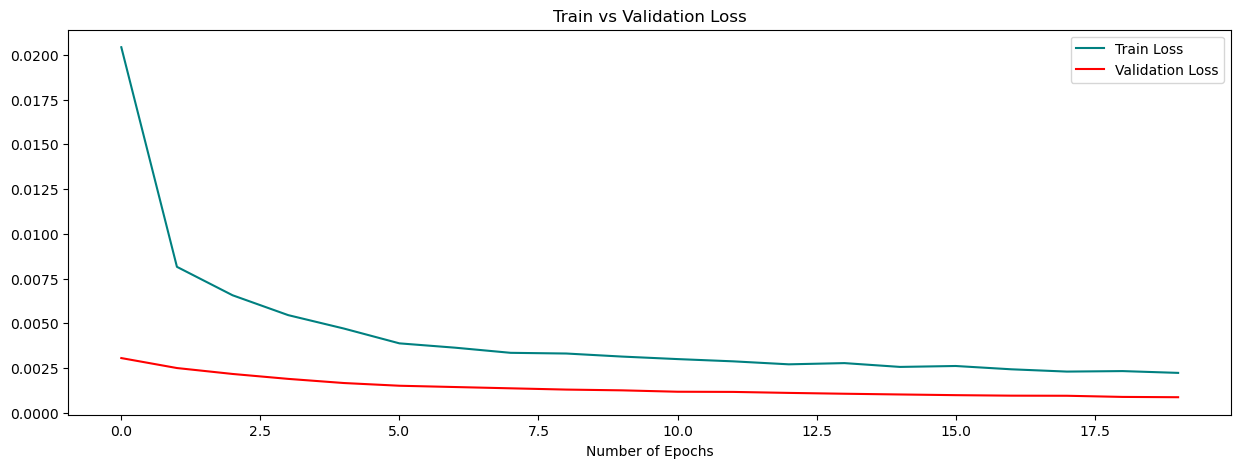

0.0022262586280703545

In [14]:
plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], color='teal', label='Train accuracy')
# plt.plot(history.history['val_accuracy'], color='red', label='Validation accuracy')
# plt.title('Train vs Validation Accuracy')
# plt.xlabel('Number of Epochs')
# plt.legend()
plt.subplot(1,1,1)
plt.plot(history.history['loss'], color='teal', label='Train Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show();
history.history['loss'][-1]

In [15]:
# Defining function to predict datas
def predicting(data, y_real):
    predicted_data = model.predict(data)
    # Invert scaling process to get the normal values range for the features 
    predicted_data = scaler.inverse_transform(predicted_data)
    y_real = scaler.inverse_transform(y_real)
    
    return predicted_data, y_real

In [16]:
# Executing predictions
train_prediction, y_train = predicting(X_train, y_train)
test_prediction, y_test = predicting(X_test, y_test)

73/73 [==============================] - 0s 232us/step


In [17]:
# Defining function to investigate the root of mean squared errors (RMSE) between predicted and real data

import math
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

def examine(y_data, predicted_data):
    score_mape = mape(y_data[:,0], predicted_data[:,0])
    score_mae = mae(y_data[:,0], predicted_data[:,0])
    score_rmse = math.sqrt(mean_squared_error(y_data[:,0], predicted_data[:,0]))
    
    print('RMSE       : ', score_rmse)
    print('MAPE       : ', score_mape)
    print('MAE       : ', score_mae)
  


    


In [18]:
# Executing the RMSE comparison
print('Trainin Data Errors')
print(examine(y_train, train_prediction),'\n')
# print(examine_mae(y_train, train_prediction),'\n')
# print(examine_r2(y_train, train_prediction),'\n')

print('Test Data Errors')
print(examine(y_test, test_prediction),'\n')
# print(examine_mae(y_test, test_prediction),'\n')
# print(examine_r2(y_test, test_prediction))


Trainin Data Errors
RMSE       :  0.07326512361457906
MAPE       :  0.10183118952769435
MAE       :  0.05454079562149074
None 

Test Data Errors
RMSE       :  0.059466299367642105
MAPE       :  0.10275055763436827
MAE       :  0.04409805882079319
None 



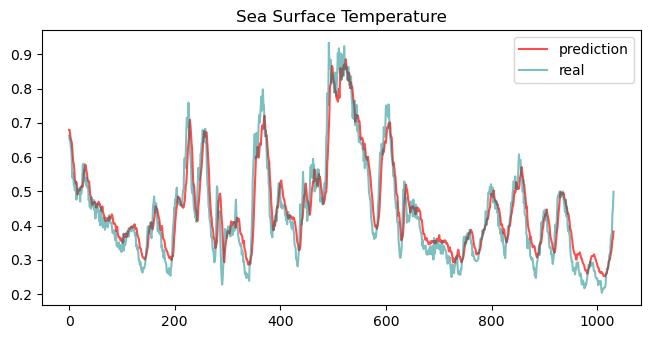

In [19]:

plt.figure(figsize=(17,25))


plt.subplot(6,2,1)
plt.plot(test_prediction[1300:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,0], color='teal', alpha=0.5, label='real')
plt.title('Sea Surface Temperature')
plt.legend()


# plt.subplot(6,2,2)
# plt.plot(test_prediction[1300:,1], color='red', alpha=0.7, label='prediction')
# plt.plot(y_test[1300:,1], color='teal', alpha=0.5, label='real')
# plt.title('Maximum Wave Height')
# plt.legend()


# plt.subplot(6,2,3)
# plt.plot(test_prediction[1300:,2], color='red', alpha=0.7, label='prediction')
# plt.plot(y_test[1300:,2], color='teal', alpha=0.5, label='real')
# plt.title('Zero Upcrossing Wave Period')
# plt.legend()


# plt.subplot(6,2,4)
# plt.plot(test_prediction[1300:,3], color='red', alpha=0.7, label='prediction')
# plt.plot(y_test[1300:,3], color='teal', alpha=0.5, label='real')
# plt.title('Peak Energy Wave Period')
# plt.legend()


# plt.subplot(6,2,5)
# plt.plot(test_prediction[1300:,4], color='red', alpha=0.7, label='prediction')
# plt.plot(y_test[1300:,4], color='teal', alpha=0.5, label='real')
# plt.title('Direction Related to True North')
# plt.legend()


# plt.subplot(6,2,6)
# plt.plot(test_prediction[1300:,5], color='red', alpha=0.7, label='prediction')
# plt.plot(y_test[1300:,5], color='teal', alpha=0.5, label='real')
# plt.title('Sea Surface Temperature')
# plt.legend()

plt.show();
